In [1]:
category = ['low', 'mid', 'high'][0]
version = 'v3'
reTrain = False
plotLoss = True

In [2]:
candDir = 'ntuples_B2DstMu_220311'
skimmedTag = ''
weights_version = 'v14_1_'
expected_RDst = 0.295

In [3]:
featuresNames = ['q2', 'Est_mu', 'M2_miss', 
                 'mu_sigIP3D_vtxDst',
#                  'mu_eta'
#                  'pt_vis', 'mass_D0pismu', 
#                  'B_eta', 
                ]

# Import

In [4]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from categoriesDef import categories
cat = categories[category]
import json, yaml

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from array import array
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import itertools

import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, rootTH1_to_np
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory
from progressBar import ProgressBar

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "       Simulation Preliminary"

Welcome to JupyROOT 6.12/07


In [6]:
webFolder = '/storage/af/user/ocerri/public_html/BPH_RDst/MVAclassifiers/' + version
if not os.path.isdir(webFolder):
    os.system('mkdir -p ' + webFolder)
    os.system('cp {f}/../index.php {f}/ '.format(f=webFolder))

In [7]:
#They all have to be produced with the same pileup
MCsample = {
######## Signals
'tau': DSetLoader('Bd_TauNuDst', candDir=candDir, skimmedTag=skimmedTag),
'mu': DSetLoader('Bd_MuNuDst', candDir=candDir, skimmedTag=skimmedTag),
######## D** background
'Bu_MuDstPi': DSetLoader('Bu_MuNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_MuDstPi': DSetLoader('Bd_MuNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
# 'Bd_MuDstPiPi': DSetLoader('Bd_MuNuDstPiPi', candDir=candDir, skimmedTag=args.skimmedTag),
'Bd_MuDstPiPi': DSetLoader('Bd_MuNuDstPiPi_v3', candDir=candDir, skimmedTag=skimmedTag),
'Bu_MuDstPiPi': DSetLoader('Bu_MuNuDstPiPi_v3', candDir=candDir, skimmedTag=skimmedTag),
'Bu_TauDstPi': DSetLoader('Bu_TauNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_TauDstPi': DSetLoader('Bd_TauNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_TauDstPiPi': DSetLoader('Bd_TauNuDstPiPi', candDir=candDir, skimmedTag=skimmedTag),
'Bu_TauDstPiPi': DSetLoader('Bu_TauNuDstPiPi', candDir=candDir, skimmedTag=skimmedTag),
'Bs_MuDstK': DSetLoader('Bs_MuNuDstK', candDir=candDir, skimmedTag=skimmedTag),
'Bs_TauDstK': DSetLoader('Bs_TauNuDstK', candDir=candDir, skimmedTag=skimmedTag),
######## D*Hc background
'Bd_DstDu': DSetLoader('Bd_DstDu', candDir=candDir, skimmedTag=skimmedTag),
'Bu_DstDu': DSetLoader('Bu_DstDu', candDir=candDir, skimmedTag=skimmedTag),
'Bd_DstDd': DSetLoader('Bd_DstDd', candDir=candDir, skimmedTag=skimmedTag),
'Bu_DstDd': DSetLoader('Bu_DstDd', candDir=candDir, skimmedTag=skimmedTag),
'Bd_DstDs': DSetLoader('Bd_DstDs', candDir=candDir, skimmedTag=skimmedTag),
'Bs_DstDs': DSetLoader('Bs_DstDs', candDir=candDir, skimmedTag=skimmedTag),
'Bd_DDs1': DSetLoader('Bd_DDs1', candDir=candDir, skimmedTag=skimmedTag),
'Bu_DDs1': DSetLoader('Bu_DDs1', candDir=candDir, skimmedTag=skimmedTag),
'B_DstDXX': DSetLoader('B_DstDXX', candDir=candDir, skimmedTag=skimmedTag),
}

dSet = {}
for n, s in MCsample.iteritems():
#     print n
    dSet[n] = pd.DataFrame(rtnp.root2array(s.skimmed_dir + '/{}_bare.root'.format(cat.name), 
                                           branches=featuresNames,
                                          ))
    wFile = s.skimmed_dir + '/weights/'+cat.name+'_bare_'+weights_version+cat.name.lower()+'_CLN_blinded.root'
    w = pd.DataFrame(rtnp.root2array(wFile, branches=['central']))
    dSet[n]['w'] = w['central']
    
    nTot = dSet[n].shape[0]
    nMax = int(1e8)
    if nTot > nMax:
        print 'Reducing', n, 'from', nTot, 'to', nMax
        dSet[n] = dSet[n][:nMax]
        dSet[n]['w'] *= nTot/float(nMax)

In [8]:
dSet['bkg'] = pd.concat([df for n, df in dSet.iteritems() if not n == 'tau'], ignore_index=True)
dSet['bkg'] = dSet['bkg'].sample(frac=1).reset_index(drop=True)

# Exploratory Plots

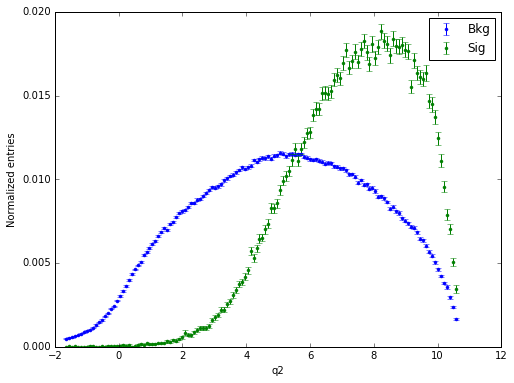

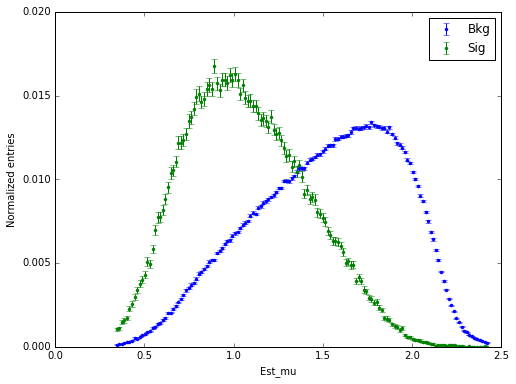

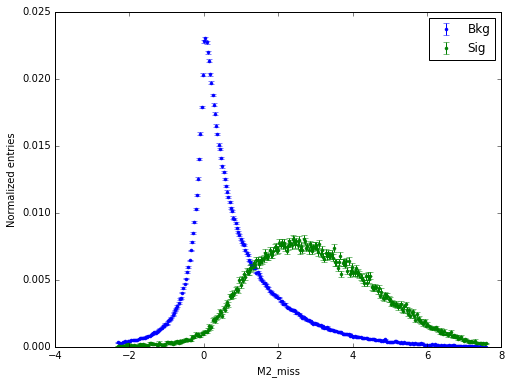

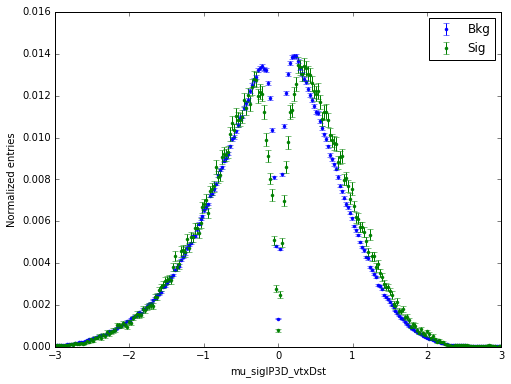

In [9]:
for var in dSet['tau'].columns:
    if var == 'w': continue
        
    hBkg = create_TH1D(dSet['bkg'][var], 'h_bkg_'+var,
                       binning=[None, np.percentile(dSet['bkg'][var], 0.1), np.percentile(dSet['bkg'][var], 99.9)],
                       weights=dSet['bkg']['w'], scale_histo='norm')
    
    hSig = create_TH1D(dSet['tau'][var], 'h_sig_'+var, 
                       weights=dSet['tau']['w'], scale_histo='norm', 
                       binning=hBkg.binning)
    
    fig = plt.figure(figsize=(8,6))
    r = rootTH1_to_np(hBkg)
    plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], label='Bkg', fmt='.')
    r = rootTH1_to_np(hSig)
    plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], label='Sig', fmt='.')
    plt.ylabel('Normalized entries')
    plt.xlabel(var)
    plt.legend(loc='best', numpoints=1)
    plt.ylim(0, plt.ylim()[1])
    if var == 'mu_sigIP3D_vtxDst':
        plt.xlim(-3,3)
    fig.savefig(webFolder+'/inputVar_{}_{}.png'.format(var, cat.name))

# Two samples splitting (Tau vs All)

In [10]:
data = pd.concat([dSet['bkg'], dSet['tau']], ignore_index=True)

X = np.array(data.drop('w', 1))
weights = np.array(data['w'])
y = np.concatenate((np.zeros(dSet['bkg'].shape[0]), np.ones(dSet['tau'].shape[0])))

nBgk = np.sum(dSet['bkg']['w'])
nSig = np.sum(dSet['tau']['w'])
weights[y==0] *=  nSig/nBgk

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.25, random_state=0)

## BDT Classifier

In [11]:
fname = '/storage/af/group/rdst_analysis/BPhysics/data/kinObsMVA/clfGBC_tauVall_{}{}.p'.format(version, cat.name)
if reTrain or not os.path.exists(fname):
    clfGBC = GradientBoostingClassifier(
        learning_rate=0.01, 
        n_estimators=1000,
        min_samples_split=50, 
        min_weight_fraction_leaf=2e-3, 
        max_depth=2,
#         validation_fraction=0.50,
#         n_iter_no_change=100,
#         tol=0.0001,
#         ccp_alpha=1e-4,
        verbose=1,
        random_state=0
    )
    clfGBC.fit(X_train, y_train, sample_weight=w_train)
    clfGBC.featuresNames = featuresNames
    pickle.dump(clfGBC, open(fname, 'wb'))
else:
    clfGBC = pickle.load(open(fname, 'rb'))
    
lTest = clfGBC.loss_(y_test, clfGBC.decision_function(X_test), sample_weight=w_test)
lTrain = clfGBC.loss_(y_train, clfGBC.decision_function(X_train), sample_weight=w_train)
print 'Loss: {:.4f} (train), {:.4f} (test)'.format(lTrain, lTest)
    
sTrain = clfGBC.score(X_train, y_train, sample_weight=w_train)
sTest = clfGBC.score(X_test, y_test, sample_weight=w_test)
print 'Accuracy: {:.4f} (train), {:.4f} (test)'.format(sTrain, sTest)

fLog = open(webFolder + '/trainingLog_'+cat.name+'.txt', 'w')
fLog.write('Loss: {:.4f} (train), {:.4f} (test) \n'.format(lTrain, lTest))
fLog.write('Accuracy: {:.4f} (train), {:.4f} (test) \n'.format(sTrain, sTest))
fLog.write('\n\nFeature importance:\n')
for x, n in zip(clfGBC.feature_importances_, featuresNames):
    fLog.write(n + ': {:.3f}'.format(x) + '\n')
    print n + ': {:.3f}'.format(x)
    
fLog.close()

Loss: 0.8794 (train), 0.8813 (test)
Accuracy: 0.7991 (train), 0.7982 (test)
q2: 0.221
Est_mu: 0.253
M2_miss: 0.469
mu_sigIP3D_vtxDst: 0.058


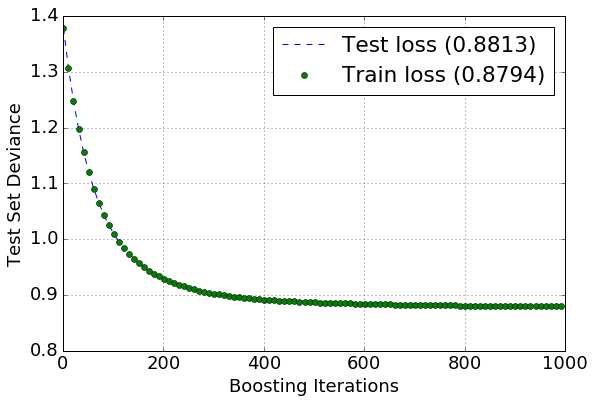

In [12]:
if plotLoss:
    test_deviance = np.zeros((clfGBC.n_estimators,), dtype=np.float64)
    train_deviance = np.zeros((clfGBC.n_estimators,), dtype=np.float64)

    for i, y_pred in enumerate(clfGBC._staged_decision_function(X_test)):
        test_deviance[i] = clfGBC.loss_(y_test, y_pred, sample_weight=w_test)
    test_deviance = test_deviance[test_deviance > 0]
    for i, y_pred in enumerate(clfGBC._staged_decision_function(X_train)):
        train_deviance[i] = clfGBC.loss_(y_train, y_pred, sample_weight=w_train)
    train_deviance = train_deviance[train_deviance > 0]
    
    plotEvery = 10
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(9,6))
    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::plotEvery], test_deviance[::plotEvery], '--', label='Test loss ({:.4f})'.format(test_deviance[-1]))
    plt.plot((np.arange(train_deviance.shape[0]) + 1)[::plotEvery], train_deviance[::plotEvery], 'o', label='Train loss ({:.4f})'.format(train_deviance[-1]))
    plt.legend(loc='best', numpoints=1)
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Test Set Deviance')
#     plt.yscale('log')
    plt.grid()
    plt.show()
    fig.savefig(webFolder+'/trainHistory_clfGBC_tauVall_{}.png'.format(cat.name))

In [13]:
histos = {}
binsq2 = [-2, 2.5, 6, 9.4, 12]
histoq2 = [{}, {}, {}, {}]
nBins = 20
hMVA_bkg = None

for n, df in dSet.iteritems():
    print n,
    if 'p_clf' in df.columns:
        df = df.drop('p_clf', 1)
    p = clfGBC.predict_proba(np.array(df.drop('w', 1)))
    dSet[n]['p_clf'] = p[:,1]
    if n == 'bkg':
        hMVA_bkg = create_TH1D(p[:,1], name='h'+n, binning=[nBins, 0, 1.3], weights=df['w'],
                                axis_title=['GBC predicted probability', 'Expected events'])
    else:
        histos[n] = create_TH1D(p[:,1], name='h'+n, binning=[nBins, 0, 1.3], weights=df['w'],
                                axis_title=['GBC predicted probability', 'Expected events'])

        for i, (q2low, q2high) in enumerate(zip(binsq2[:-1], binsq2[1:])):
            sel = np.logical_and(df['q2'] >= q2low, df['q2'] < q2high)
            histoq2[i][n] = create_TH1D(p[:,1][sel], name='hq2'+n+str(i), binning=[nBins, 0, 1.3], 
                                       weights=df['w'][sel],
                                       axis_title=['GBC predicted probability', 'Expected events']
                                      )
histos['data'] = histos['mu'].Clone('placeholderData')
histos['data'].Reset()
for i, hdic in enumerate(histoq2):
    hdic['data'] = hdic['mu'].Clone('placeholderData_q2'+str(i))
    hdic['data'].Reset()

tau B_DstDXX Bu_DDs1 Bu_MuDstPiPi Bu_DstDu Bu_MuDstPi Bu_DstDd Bd_MuDstPiPi bkg Bd_TauDstPi Bd_MuDstPi Bd_DDs1 Bs_MuDstK Bu_TauDstPiPi Bs_TauDstK Bd_DstDd Bs_DstDs Bu_TauDstPi mu Bd_DstDs Bd_TauDstPiPi Bd_DstDu


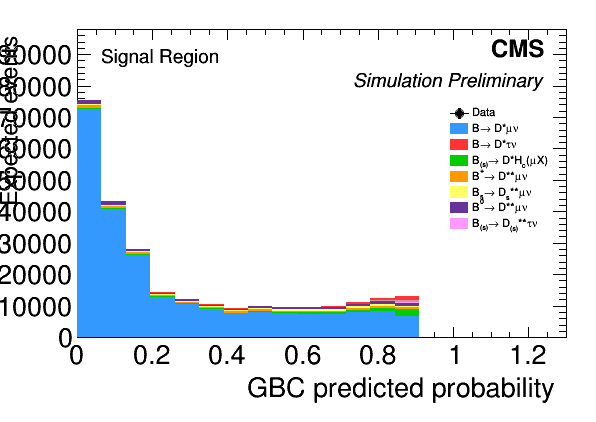

In [14]:
c = plot_SingleCategory(CMS_lumi, histos, scale_dic={'tau': expected_RDst},
                        addText='Signal Region', min_y=0, tag='lin', logy=False,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['mu', 'DstHc', 'Dstst','B_DstDXX', 'tau']
                       )
c.Draw()
c.SaveAs(webFolder+'/MVAscores_{}.png'.format(cat.name))

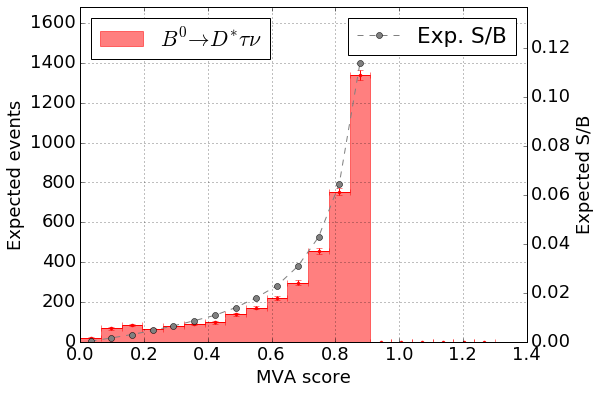

In [15]:
rSig = rootTH1_to_np(histos['tau'])
rSig[:,1] *= expected_RDst
rBkg = rootTH1_to_np(hMVA_bkg)

fig = plt.figure(figsize=(8,6))
step = 0.5*(rSig[1,0] - rSig[0,0])
plt.errorbar(rSig[:,0], rSig[:,1], yerr=rSig[:,2], xerr=step, fmt='r.')
x, y = [], []
for r in rSig:
    x.append(r[0]-step)
    x.append(r[0]+step)
    y.append(r[1])
    y.append(r[1])
o1 = plt.fill_between(x, y, color='red', alpha=0.5, label=r'$B^{0} \to D^{*}\tau\nu$')
plt.ylabel('Expected events')
plt.grid()
plt.ylim(0, plt.ylim()[1]*1.2)
plt.xlabel('MVA score')
plt.legend(loc='upper left', numpoints=1)

ax2 = plt.gca().twinx()
sel = rBkg[:,1] > 0
r = rSig[:,1][sel] / rBkg[:,1][sel]
o2 = ax2.plot(rSig[:,0][sel], r, '--o', color='gray', label='Exp. S/B')
ax2.set_ylabel('Expected S/B')
ax2.legend(loc='upper right', numpoints=1)
ax2.set_ylim(0, 1.2*np.max(r))
fig.savefig(webFolder+'/MVAscores_expSig_{}.png'.format(cat.name))

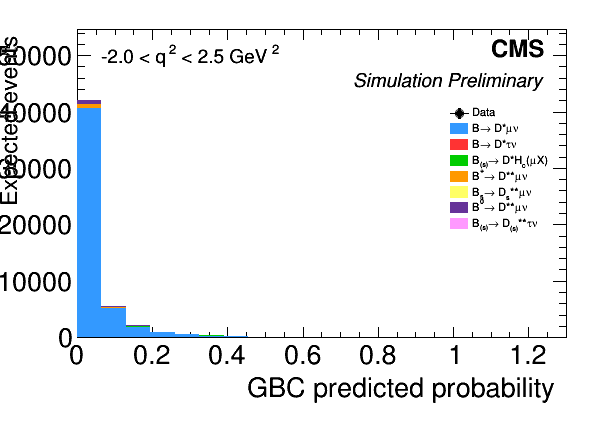

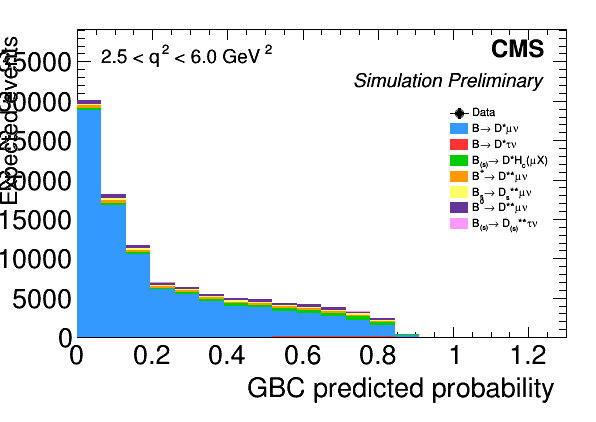

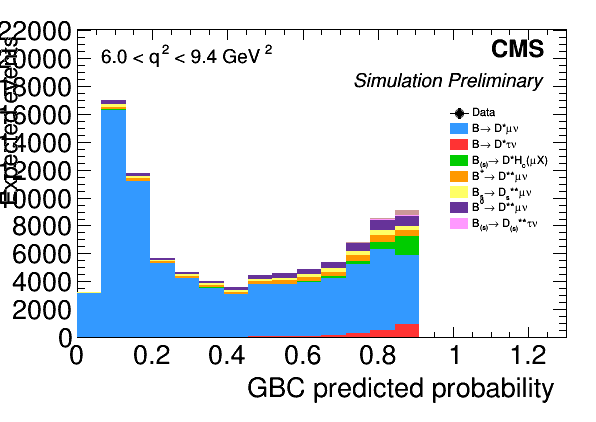

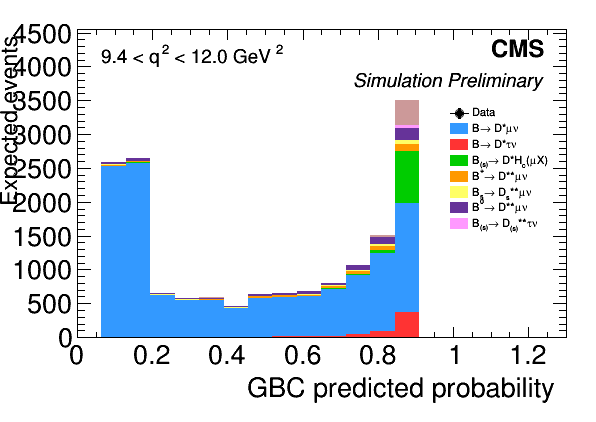

In [16]:
cvs = len(histoq2)*[None]
for i, hdic in enumerate(histoq2):
    q2Text = '{:.1f} < q^{{2}} < {:.1f} GeV^{{2}}'.format(binsq2[i], binsq2[i+1])
    cvs[i] = plot_SingleCategory(CMS_lumi, hdic, scale_dic={'tau': expected_RDst},
                        addText=q2Text, min_y=0, tag='logq2'+str(i), logy=False,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['tau', 'mu','DstHc', 'Dstst','B_DstDXX']
                       )
    cvs[i].Draw()
    cvs[i].SaveAs(webFolder+'/MVAscore_q2bin{}_{}.png'.format(i, cat.name))

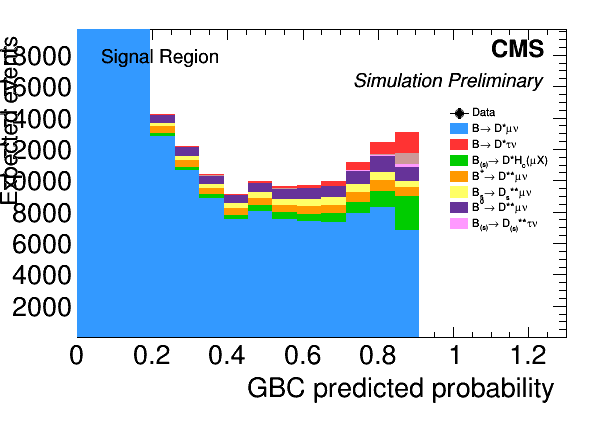

In [17]:
h_tot = hMVA_bkg.Clone('h_tot')
h_tot.Add(histos['tau'], expected_RDst)
r = rootTH1_to_np(h_tot)

C = plot_SingleCategory(CMS_lumi, histos, scale_dic={'tau': expected_RDst},
                        addText='Signal Region', min_y=1, tag='linZoom', logy=False,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['mu', 'DstHc', 'Dstst', 'B_DstDXX', 'tau'],
                        max_y = 1.5*np.max(r[:,1][r[:,0] > 0.6])
                       )
C.Draw()
C.SaveAs(webFolder+'/MVAscore_zoom_{}.png'.format(cat.name))

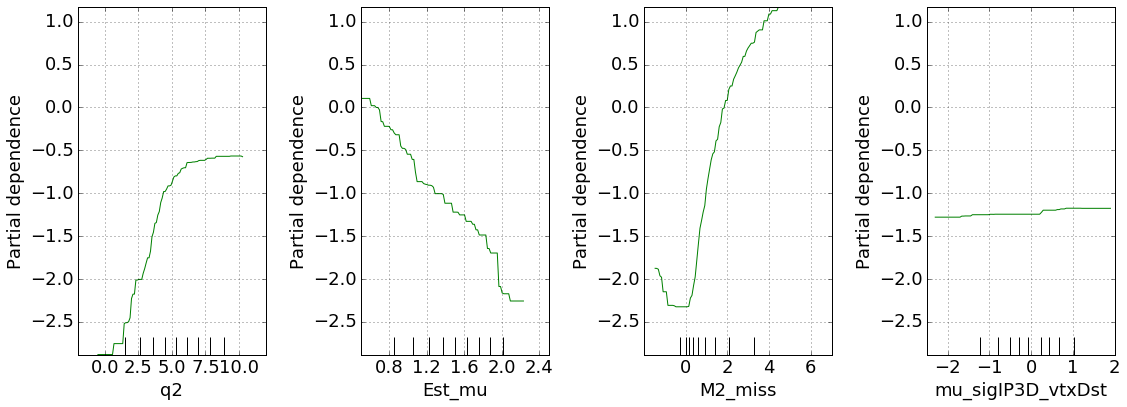

In [18]:
nFeat = len(clfGBC.featuresNames)
fig, axs = plot_partial_dependence(clfGBC, X_train, range(nFeat), 
                                   feature_names=clfGBC.featuresNames,
                                   percentiles=(0.01,0.99),
                                   n_cols=nFeat,
                                   figsize=(16,6)
                                  ) 
fig.tight_layout()
for a in axs: a.grid()
fig.savefig(webFolder+'/partialDependence1D_{}.png'.format(cat.name))

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numpy/1.14.1-gnimlf/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numpy/1.14.1-gnimlf/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


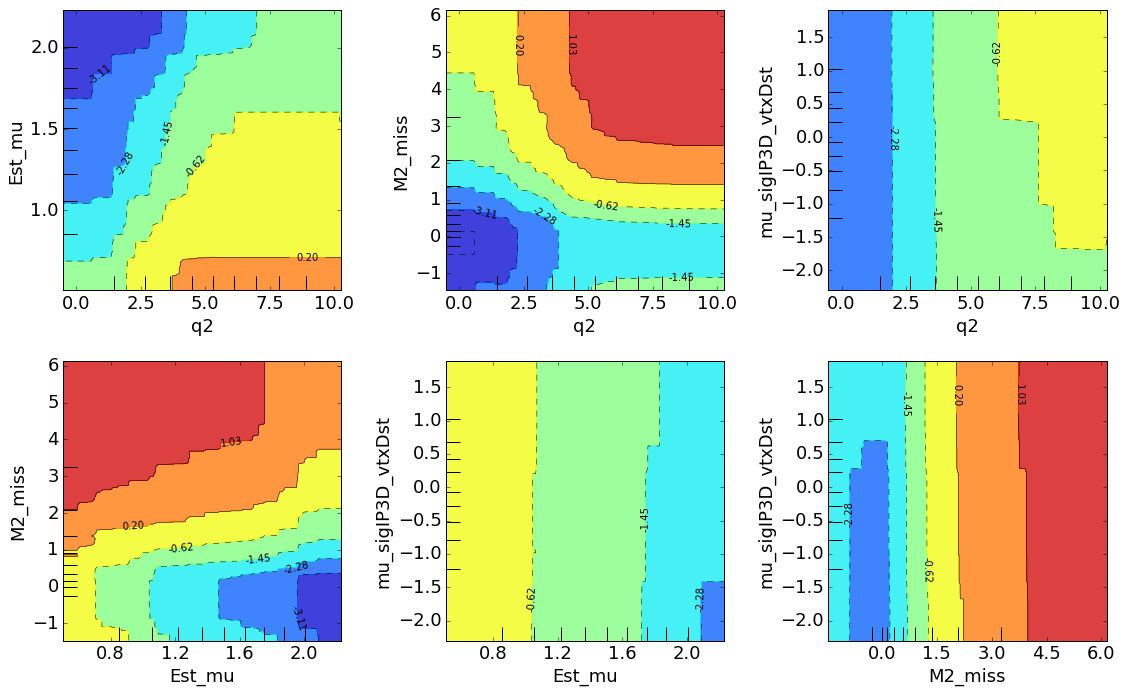

In [19]:
featToPlt = list(itertools.combinations(range(nFeat), 2))
fig, axs = plot_partial_dependence(clfGBC, X_train, featToPlt, 
                                   feature_names=clfGBC.featuresNames,
                                   percentiles=(0.01,0.99),
                                   n_cols=len(clfGBC.featuresNames) -1,
                                   figsize=(16,10)
                                  ) 
fig.tight_layout()
fig.savefig(webFolder+'/partialDependence2D_{}.png'.format(cat.name))